In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from poglm import utils, inference

In [2]:
n_neurons = 5
n_vis_neurons = 3
n_hid_neurons = 2
vari_list = ['F', 'FS', 'FB']
distribution_list = np.array(['Poisson', 'categorical', 'GS-score', 'GS-pathwise', 'exponential', 'Rayleigh', 'half-normal'])
distribution_abbr_dict = {'Poisson': 'Pois', 'categorical': 'Cat', 'GS-score': 'GS-s', 'GS-pathwise': 'GS-p', 'exponential': 'Exp', 'Rayleigh': 'Ray', 'half-normal': 'HN'}
distribution_abbr_list = np.array(list(distribution_abbr_dict.values()))
trial_list = np.arange(10)
seed_list = np.arange(10)
# seed_list = np.arange(5)

In [3]:
data = pd.read_pickle('data.pkl')

df_list = []
for vari in vari_list:
    for distribution in distribution_list:
        for trial in trial_list:
            for seed in seed_list:
                try:
                    df_temp = pd.read_csv(f'csv/{vari}_{distribution}_{trial}_{seed}.csv')
                    df_temp['weight error'] = (data.at[trial, 'gen_model']['linear.weight'] - torch.load(f'model/{vari}_{distribution}_{trial}_{seed}_inf.pt')['linear.weight']).abs().mean().item()
                    df_temp['bias error'] = (data.at[trial, 'gen_model']['linear.bias'] - torch.load(f'model/{vari}_{distribution}_{trial}_{seed}_inf.pt')['linear.bias']).abs().mean().item()
                    df_temp['vari'] = vari
                    df_temp['distribution'] = distribution_abbr_dict[distribution]
                    df_temp['trial'] = trial
                    df_temp['seed'] = seed
                    df_list.append(df_temp)
                except:
                    print(vari, distribution, trial, seed)
                    pass


df = pd.concat(df_list, ignore_index=True)

In [4]:
df

,pred complete log-likelihood,hid log-likelihood,marginal log-likelihood,ELBO,time,weight error,bias error,vari,distribution,trial,seed
0,-408.489796,-220.703027,-190.231998,-191.611687,0.961260,0.709475,0.742308,F,Pois,0,0
1,-437.168330,-251.050317,-190.513157,-191.681845,0.960777,0.699846,0.712488,F,Pois,0,1
2,-440.921106,-251.639846,-190.367375,-191.193519,0.989712,0.682121,0.719002,F,Pois,0,2
3,-419.785443,-232.407536,-190.288696,-191.131928,0.989371,0.750082,0.601033,F,Pois,0,3
4,-448.466888,-252.608001,-190.392728,-191.075874,0.989413,0.633234,1.025707,F,Pois,0,4
...,...,...,...,...,...,...,...,...,...,...,...
2095,-514.280513,-208.694896,-305.771373,-305.935297,1.519856,0.612635,0.365013,FB,HN,9,5
2096,-516.737938,-211.873234,-305.739009,-305.872163,1.505860,0.580975,0.373110,FB,HN,9,6
2097,-515.814833,-209.751192,-305.750989,-305.903096,1.505864,0.583162,0.366566,FB,HN,9,7
2098,-512.881555,-208.302307,-305.755615,-305.960121,1.505872,0.588461,0.376824,FB,HN,9,8


In [6]:
df_1 = df.groupby(['vari', 'distribution', 'seed']).mean().reset_index()

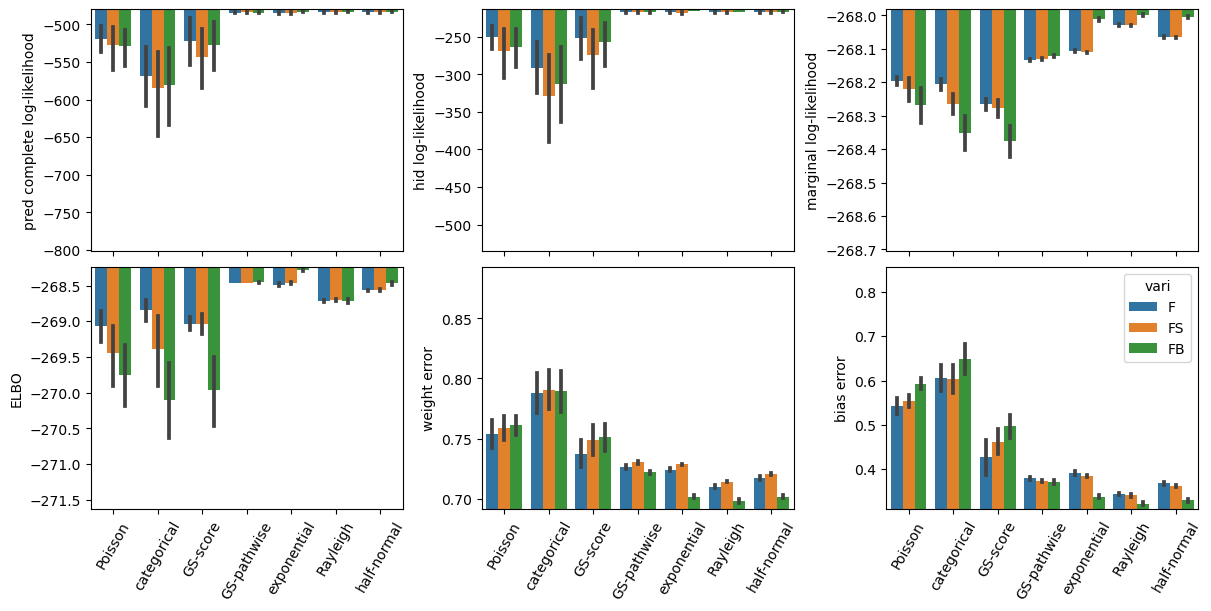

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True, sharex=True)
axs = axs.flat

ax = sns.barplot(x='distribution', y='pred complete log-likelihood', hue='vari', data=df_1, ax=axs[0], order=distribution_list, hue_order=vari_list)
ax.set(xlabel=None, ylim=(df_1['pred complete log-likelihood'].min(), df_1['pred complete log-likelihood'].max()))
ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='distribution', y='hid log-likelihood', hue='vari', data=df_1, ax=axs[1], order=distribution_list, hue_order=vari_list)
ax.set(xlabel=None, ylim=(df_1['hid log-likelihood'].min(), df_1['hid log-likelihood'].max()))
ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='distribution', y='marginal log-likelihood', hue='vari', data=df_1, ax=axs[2], order=distribution_list, hue_order=vari_list, errorbar='se')
ax.set(xlabel=None, ylim=(df_1['marginal log-likelihood'].min(), df_1['marginal log-likelihood'].max()))
ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='distribution', y='ELBO', hue='vari', data=df_1, ax=axs[3], order=distribution_list, hue_order=vari_list)
ax.set(xlabel=None, ylim=(df_1['ELBO'].min(), df_1['ELBO'].max()))
ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='distribution', y='weight error', hue='vari', data=df_1, ax=axs[4], order=distribution_list, hue_order=vari_list, errorbar='se')
ax.set(xlabel=None, ylim=(df_1['weight error'].min(), df_1['weight error'].max()))
ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='distribution', y='bias error', hue='vari', data=df_1, ax=axs[5], order=distribution_list, hue_order=vari_list, errorbar='se')
ax.set(xlabel=None, ylim=(df_1['bias error'].min(), df_1['bias error'].max()))
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)
# ax.get_legend().remove()
# fig.savefig(f'{folder}_metric.pdf')

Text(0.5, 0.98, 'Learned $q$')

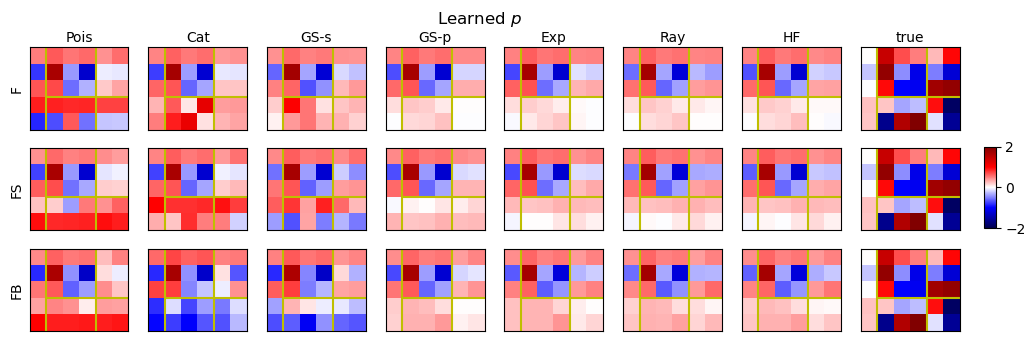

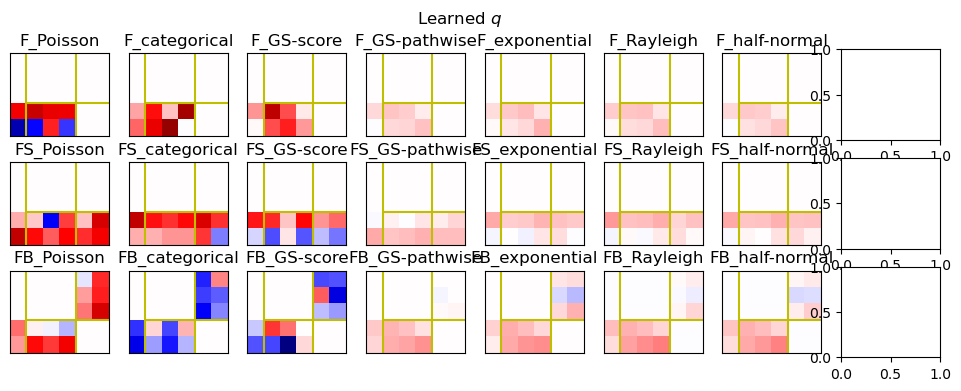

In [22]:
trial = 7
seed = 9

fig, axs = plt.subplots(3, 8, figsize=(12, 3.7))

for i, vari in enumerate(vari_list):
    w = data.at[trial, 'gen_model']
    im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, 7], v=2)
#     axs[i, 7].set(title='true')
    for j, distribution in enumerate(distribution_list):
        try:
            w = torch.load(f'model/{vari}_{distribution}_{trial}_{seed}_inf.pt')
            im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
#             axs[i, j].set(title=f'{vari}_{distribution}')
        except:
            pass

for i in range(len(vari_list)):
    axs[i, 0].set_ylabel(vari_list[i])
for j in range(7):
    ax = axs[0, j]
    ax.set_xlabel(distribution_abbr_list[j])
    ax.xaxis.set_label_position('top')
axs[0, 7].set_xlabel('true')
axs[0, 7].xaxis.set_label_position('top')
fig.colorbar(im, cax=fig.add_axes([0.92, 0.39, 0.01, 0.22]), orientation='vertical')

fig.suptitle('Learned $p$')

fig, axs = plt.subplots(3, 8, figsize=(12, 4))

for i, vari in enumerate(vari_list):
    for j, distribution in enumerate(distribution_list):
        try:
            w = torch.load(f'model/{vari}_{distribution}_{trial}_{seed}_vari.pt')
            im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
            axs[i, j].set(title=f'{vari}_{distribution}')
        except:
            pass
fig.suptitle('Learned $q$')

# fig.colorbar(im, cax=fig.add_axes([0.92, 0.32, 0.02, 0.35]), orientation='vertical')

# fig.savefig('poglm_w.pdf', bbox_inches='tight', transparent=True)

In [6]:
df_loss_list = []
for vari in vari_list:
    for distribution in distribution_list:
        for trial in trial_list[0:1]:
            for seed in seed_list:
                try:
                    with open(f'npy/{vari}_{distribution}_{trial}_{seed}.npy', 'rb') as f:
                        df_temp = pd.DataFrame({'loss': np.load(f), 'epoch': np.arange(20), 'vari': vari, 'distribution': distribution_abbr_dict[distribution], 'trial': trial, 'seed': seed})
#                     df_temp['vari'] = vari
#                     df_temp['distribution'] = distribution
#                     df_temp['trial'] = trial
#                     df_temp['seed'] = seed
                    df_loss_list.append(df_temp)
                except:
                    print(vari, distribution, trial, seed)
                    pass


df_loss = pd.concat(df_loss_list, ignore_index=True)

/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py

Text(0.02, 0.5, 'training loss')

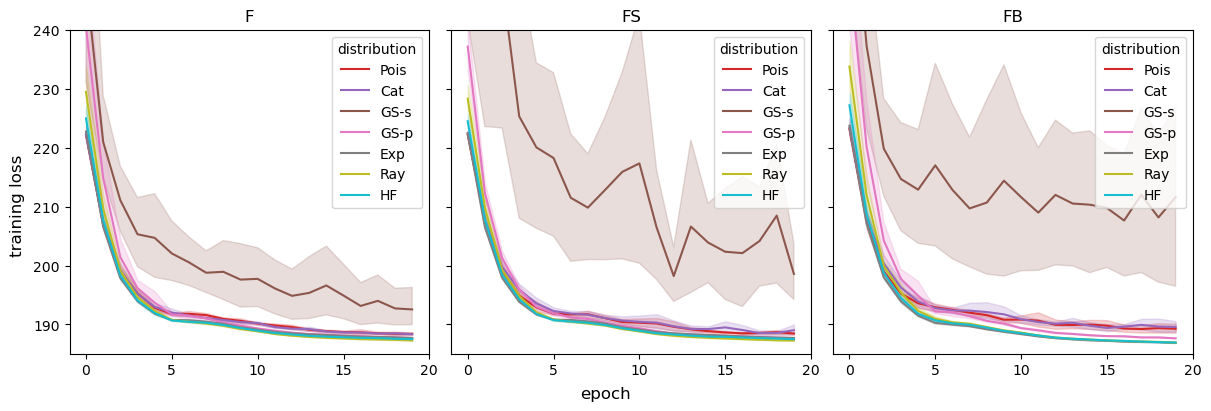

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), layout='constrained', sharex=True, sharey=True)

for vari, ax in zip(vari_list, axs):
    ax = sns.lineplot(x='epoch', y='loss', hue='distribution', data=df_loss[df_loss.vari == vari], ax=ax, palette=['C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])
    ax.set(ylabel=None, xlabel=None, ylim=(185, 240), xticks=[0, 5, 10, 15, 20], title=vari)
fig.supxlabel('epoch')
fig.supylabel('training loss')

/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py

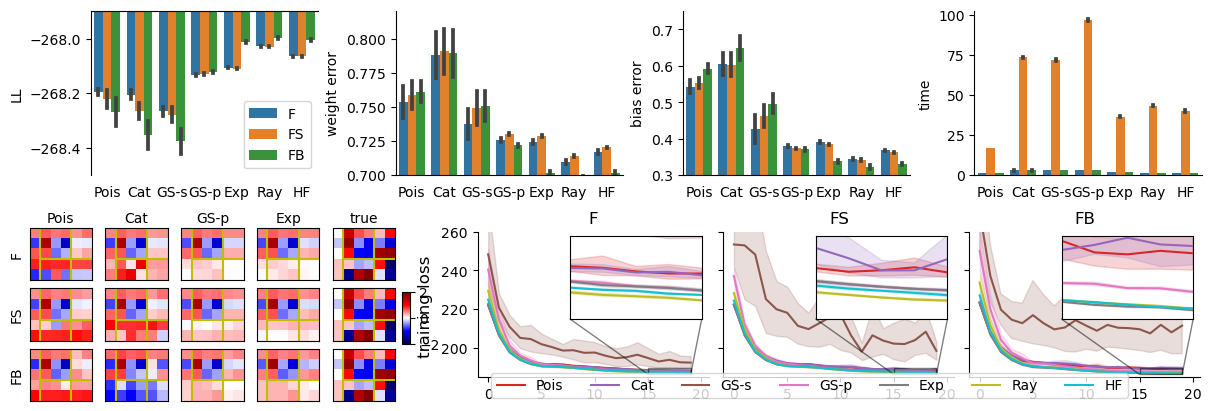

In [7]:
trial = 7
seed = 9

fig = plt.figure(layout='constrained', figsize=(12, 4))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1])

## barplot
axs = subfigs[0].subplots(1, 4)
ax = sns.barplot(x='distribution', y='marginal log-likelihood', hue='vari', data=df_1, ax=axs[0], order=distribution_abbr_list, hue_order=vari_list, errorbar='se')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel=None, ylabel='LL', ylim=(-268.5, -267.9))
# ax.xaxis.set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.get_legend().set(title=None)

ax = sns.barplot(x='distribution', y='weight error', hue='vari', data=df_1, ax=axs[1], order=distribution_abbr_list, hue_order=vari_list, errorbar='se')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel=None, ylim=(0.7, 0.82))
# ax.xaxis.set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.get_legend().remove()

ax = sns.barplot(x='distribution', y='bias error', hue='vari', data=df_1, ax=axs[2], order=distribution_abbr_list, hue_order=vari_list, errorbar='se')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel=None, ylim=(0.3, 0.75))
# ax.xaxis.set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.get_legend().remove()

ax = sns.barplot(x='distribution', y='time', hue='vari', data=df_1, ax=axs[3], order=distribution_abbr_list, hue_order=vari_list, errorbar='se')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel=None)
# ax.xaxis.set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.get_legend().remove()

subsubfigs = subfigs[1].subfigures(1, 2, width_ratios=[1, 2])
## weight
axs = subsubfigs[0].subplots(3, 5)
for i, vari in enumerate(vari_list):
    for j, distribution in zip(range(4), distribution_list[[0, 1, 3, 4]]):
        w = torch.load(f'model/{vari}_{distribution}_{trial}_{seed}_inf.pt')
        im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
    w = data.at[trial, 'gen_model']
    im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, 4], v=2)
for i in range(len(vari_list)):
    axs[i, 0].set_ylabel(vari_list[i])
for j in range(4):
    ax = axs[0, j]
    ax.set_xlabel(distribution_abbr_list[[0, 1, 3, 4]][j])
    ax.xaxis.set_label_position('top')
axs[0, 4].set_xlabel('true')
axs[0, 4].xaxis.set_label_position('top')
subsubfigs[0].colorbar(im, cax=subsubfigs[0].add_axes([1, 0.31, 0.02, 0.26]), orientation='vertical')

## loss curves
axs = subsubfigs[1].subplots(1, 3, sharex=True, sharey=True)
for vari, ax in zip(vari_list, axs):
    ax = sns.lineplot(x='epoch', y='loss', hue='distribution', data=df_loss[df_loss.vari == vari], ax=ax, palette=['C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])
    ax.set(ylabel=None, xlabel=None, ylim=(185, 260), xticks=[0, 5, 10, 15, 20], title=vari)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_legend().remove()
    
    axins = ax.inset_axes([0.4, 0.4, 0.57, 0.57])
    sns.lineplot(x='epoch', y='loss', hue='distribution', data=df_loss[df_loss.vari == vari], ax=axins, palette=['C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])
    axins.set(ylabel=None, xlabel=None, ylim=(186.5, 190), xlim=(15, 19), xticks=[], yticks=[])
    axins.get_legend().remove()
    ax.indicate_inset_zoom(axins, edgecolor="black")
    
handles, labels = ax.get_legend_handles_labels()
subsubfigs[1].supylabel('training loss')
subsubfigs[1].legend(handles, labels, ncol=7, loc='lower center')

fig.savefig('synthetic.pdf', bbox_inches='tight')

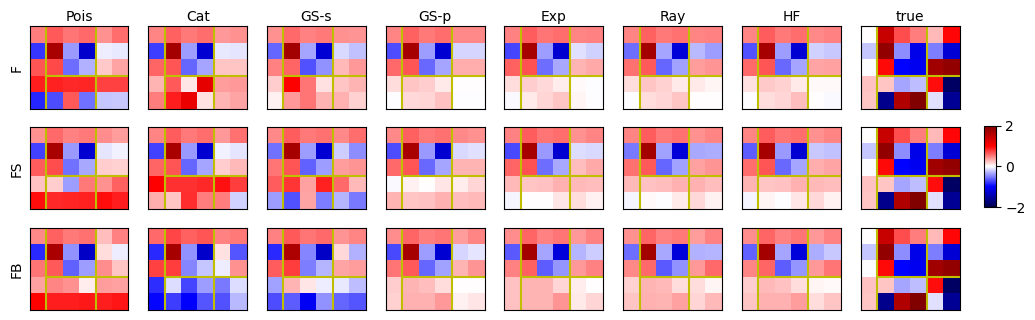

In [23]:
trial = 7
seed = 9

fig, axs = plt.subplots(3, 8, figsize=(12, 3.7))

for i, vari in enumerate(vari_list):
    w = data.at[trial, 'gen_model']
    im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, 7], v=2)
#     axs[i, 7].set(title='true')
    for j, distribution in enumerate(distribution_list):
        try:
            w = torch.load(f'model/{vari}_{distribution}_{trial}_{seed}_inf.pt')
            im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
#             axs[i, j].set(title=f'{vari}_{distribution}')
        except:
            pass

for i in range(len(vari_list)):
    axs[i, 0].set_ylabel(vari_list[i])
for j in range(7):
    ax = axs[0, j]
    ax.set_xlabel(distribution_abbr_list[j])
    ax.xaxis.set_label_position('top')
axs[0, 7].set_xlabel('true')
axs[0, 7].xaxis.set_label_position('top')
fig.colorbar(im, cax=fig.add_axes([0.92, 0.39, 0.01, 0.22]), orientation='vertical')
fig.savefig('synthetic_weight.pdf', bbox_inches='tight', transparent=True)

In [7]:
df_2 = df_1.copy()
df_2['marginal log-likelihood'] = df_2['marginal log-likelihood'] / (3 * 100)

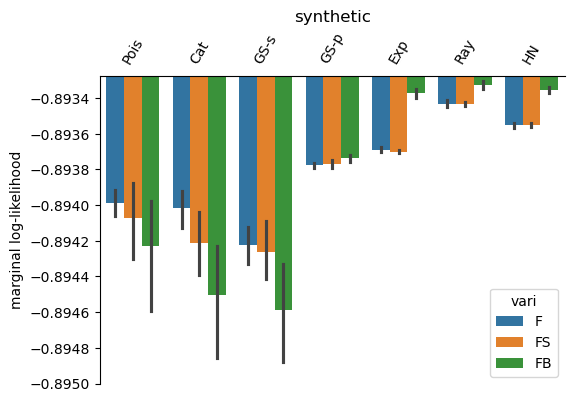

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax = sns.barplot(x='distribution', y='marginal log-likelihood', hue='vari', data=df_2, ax=ax, order=distribution_abbr_list, hue_order=vari_list)
ax.set(xlabel=None, ylim=(-0.8950, df_2['marginal log-likelihood'].max()), title='synthetic')
ax.tick_params(axis='x', rotation=60)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_ticks_position('none')

fig.savefig(f'synthetic_CI.pdf', bbox_inches='tight', transparent=True)